# Simulación teniendo en cuenta clústers de usuarios e ítems

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

def generate_mask_zipf_global(
    U: int,
    I: int,
    density: float = 0.01,
    alpha_user: float = 1.1,
    alpha_item: float = 1.2,
    seed: int = 0,
    oversample: float = 1.5,
    min_user_ratings: int | None = None,
    min_item_ratings: int | None = None,
    # --- NEW (optional) cluster params ---
    n_user_clusters: int | None = None,
    n_item_clusters: int | None = None,
    beta: float = 0.0,                 # 0 -> original mask (no taste bias)
    affinity: np.ndarray | None = None, # shape (G,H). If None, random.
    return_clusters: bool = False,      # if True returns (pairs, user_cluster, item_cluster, affinity)
):
    """
    Generates ~M unique (u,i) pairs with long-tailed user and item marginals.

    NEW (optional):
      If n_user_clusters and n_item_clusters are set and beta != 0:
        - each user u has cluster g(u)
        - each item i has cluster h(i)
        - items are sampled conditional on user cluster:
            P(i|u) ∝ pi[i] * exp(beta * affinity[g(u), h(i)])
    """
    if U <= 0 or I <= 0:
        return [] if not return_clusters else ([], None, None, None)

    if min_user_ratings is not None and min_user_ratings < 0:
        raise ValueError("min_user_ratings must be >= 0 or None.")
    if min_item_ratings is not None and min_item_ratings < 0:
        raise ValueError("min_item_ratings must be >= 0 or None.")
    if min_user_ratings is not None and min_user_ratings > I:
        raise ValueError("min_user_ratings cannot exceed I (unique items per user).")
    if min_item_ratings is not None and min_item_ratings > U:
        raise ValueError("min_item_ratings cannot exceed U (unique users per item).")

    rng = np.random.default_rng(seed)
    M = int(round(density * U * I))
    M = max(0, min(M, U * I))
    if M == 0 and (min_user_ratings is None and min_item_ratings is None):
        return [] if not return_clusters else ([], None, None, None)

    # User probs (Zipf by rank) + permute IDs
    ru = np.arange(1, U + 1, dtype=np.float64)
    pu = ru ** (-alpha_user)
    pu /= pu.sum()
    pu = pu[rng.permutation(U)]

    # Item probs (Zipf by rank) + permute IDs
    ri = np.arange(1, I + 1, dtype=np.float64)
    pi = ri ** (-alpha_item)
    pi /= pi.sum()
    pi = pi[rng.permutation(I)]

    # -------------------------
    # NEW: clusters (optional)
    # -------------------------
    use_clusters = (
        n_user_clusters is not None
        and n_item_clusters is not None
        and n_user_clusters >= 2
        and n_item_clusters >= 2
        and float(beta) != 0.0
    )

    user_cluster = None
    item_cluster = None
    A = None
    pi_by_g = None

    if use_clusters:
        G = int(n_user_clusters)
        H = int(n_item_clusters)

        user_cluster = rng.integers(0, G, size=U, dtype=np.int64)
        item_cluster = rng.integers(0, H, size=I, dtype=np.int64)

        if affinity is None:
            A = rng.normal(0.0, 1.0, size=(G, H))
            # small diagonal boost if square (optional, keeps things "genre-like" but still simple)
            if G == H:
                A = A + 0.5 * np.eye(G)
        else:
            A = np.asarray(affinity, dtype=np.float64)
            if A.shape != (G, H):
                raise ValueError(f"affinity must have shape ({G},{H})")

        # Precompute per-user-cluster item distributions:
        # pi_g[i] ∝ pi[i] * exp(beta * A[g, item_cluster[i]])
        pi_by_g = np.empty((G, I), dtype=np.float64)
        ic = item_cluster  # alias
        for g in range(G):
            logits = float(beta) * A[g, ic]           # length I
            logits = logits - logits.max()            # stabilize
            pg = pi * np.exp(logits)
            pg = pg / pg.sum()
            pi_by_g[g] = pg

    # Collect unique (u,i) pairs via integer keys
    keys = np.empty(0, dtype=np.int64)

    while keys.size < M:
        need = M - keys.size
        batch = int(np.ceil(need * oversample)) + 32

        u = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)

        if not use_clusters:
            i = rng.choice(I, size=batch, replace=True, p=pi).astype(np.int64)
        else:
            i = np.empty(batch, dtype=np.int64)
            gu = user_cluster[u]
            # loop only over clusters (small), not users
            for g in range(pi_by_g.shape[0]):
                idx = np.where(gu == g)[0]
                if idx.size:
                    i[idx] = rng.choice(I, size=idx.size, replace=True, p=pi_by_g[g]).astype(np.int64)

        k = u * np.int64(I) + i
        keys = np.unique(np.concatenate([keys, k]))

    if keys.size > M:
        keys = rng.choice(keys, size=M, replace=False)
    keys = keys[:M]

    # ---- Enforce minima (may add extra pairs) ----
    if min_user_ratings is not None or min_item_ratings is not None:
        key_set = set(keys.tolist())

        # current degrees
        u0 = (keys // I).astype(np.int64)
        i0 = (keys % I).astype(np.int64)
        user_deg = np.bincount(u0, minlength=U).astype(np.int64)
        item_deg = np.bincount(i0, minlength=I).astype(np.int64)

        def add_pair(uu: int, ii: int):
            kk = int(uu) * int(I) + int(ii)
            if kk in key_set:
                return False
            key_set.add(kk)
            user_deg[uu] += 1
            item_deg[ii] += 1
            return True

        # 1) ensure min per user  (UPDATED: if clusters enabled, sample items from that user's cluster)
        if min_user_ratings is not None:
            for uu in np.where(user_deg < min_user_ratings)[0]:
                need_u = int(min_user_ratings - user_deg[uu])
                tries = 0
                while need_u > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_u * oversample)) + 32

                    if not use_clusters:
                        p_items = pi
                    else:
                        g = int(user_cluster[uu])
                        p_items = pi_by_g[g]

                    cand_items = rng.choice(I, size=batch, replace=True, p=p_items).astype(np.int64)
                    cand_items = np.unique(cand_items)

                    added = 0
                    for ii in cand_items:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_u -= 1
                            if need_u == 0:
                                break
                    tries = tries + 1 if added == 0 else 0

        # 2) ensure min per item (kept as you had it: users sampled from pu)
        if min_item_ratings is not None:
            for ii in np.where(item_deg < min_item_ratings)[0]:
                need_i = int(min_item_ratings - item_deg[ii])
                tries = 0
                while need_i > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_i * oversample)) + 32
                    cand_users = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)
                    cand_users = np.unique(cand_users)

                    added = 0
                    for uu in cand_users:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_i -= 1
                            if need_i == 0:
                                break
                    tries = tries + 1 if added == 0 else 0

        keys = np.fromiter(key_set, dtype=np.int64)

    u = (keys // I).astype(int)
    i = (keys % I).astype(int)
    pairs = list(zip(u.tolist(), i.tolist()))

    if return_clusters:
        return pairs, user_cluster, item_cluster, A
    return pairs


In [29]:
U, I = 1000, 2000
pairs, user_cluster, item_cluster, affinity = generate_mask_zipf_global(
    U, 
    I, 
    density=0.063, 
    alpha_user=0.55, alpha_item=.7, 
    seed=42, min_user_ratings=20, min_item_ratings=5,
    n_user_clusters=12,
    n_item_clusters=18,
    beta=1.2,      # taste strength in the mask
    return_clusters=True,
)

In [30]:

# ---------- Helpers: discretization to 1..5 ----------

def _discretize_scores_to_ratings(
    s: np.ndarray,
    rating_probs: np.ndarray | None = None,  # probs for [1,2,3,4,5]
) -> np.ndarray:
    """
    Map continuous scores -> integer ratings 1..5.

    If rating_probs is None:
        round + clip.
    Else:
        quantile-binning so the marginal rating distribution roughly matches rating_probs.
        (This is usually nicer when you want MovieLens-like marginals.)
    """
    if rating_probs is None:
        r = np.clip(np.rint(s), 1, 5).astype(np.int64)
        return r

    p = np.asarray(rating_probs, dtype=np.float64)
    if p.shape != (5,):
        raise ValueError("rating_probs must have shape (5,) for ratings 1..5.")
    p = p / p.sum()

    # Compute cutpoints so that P(r<=k) matches cumulative probs approximately.
    # We bin by quantiles of the generated score distribution.
    cdf = np.cumsum(p)  # length 5, last = 1
    # We need 4 interior thresholds between 1..5
    qs = cdf[:-1]  # 4 numbers in (0,1)
    cuts = np.quantile(s, qs)

    # digitize: returns 0..4 -> add 1 => 1..5
    r = (np.digitize(s, cuts, right=True) + 1).astype(np.int64)
    return r


# ---------- Main: latent-factor rating filler ----------

def fill_ratings_from_mask_latent(
    U: int,
    I: int,
    pairs: list[tuple[int, int]],
    seed: int = 0,
    rating_probs: np.ndarray | None = None,  # optional target marginals for [1..5]
    k: int = 20,          # latent dimension
    mu: float = 3.6,      # global mean (MovieLens-ish)
    sigma_bu: float = 0.35,
    sigma_bi: float = 0.25,
    sigma_f: float = 0.9,  # overall strength of latent factors
    sigma_eps: float = 0.75,  # noise (bigger -> weaker user-user correlation)
    dtype=np.float32,
) -> np.ndarray:
    """
    Returns R (U x I) with NaN for missing and integer ratings 1..5 on masked entries.

    Model (for observed entries only):
        s_ui = mu + b_u + b_i + <p_u, q_i> + eps

    Then discretize scores to 1..5:
        - if rating_probs is None: round+clip
        - else: quantile-bin so the marginal matches rating_probs ~ (useful to mimic ML-100k rating skew)

    Tune sigma_eps (and sigma_f) to match MovieLens user-user similarity distribution.
    """
    rng = np.random.default_rng(seed)
    R = np.full((U, I), np.nan, dtype=dtype)

    if len(pairs) == 0:
        return R

    u = np.fromiter((p[0] for p in pairs), dtype=np.int64, count=len(pairs))
    i = np.fromiter((p[1] for p in pairs), dtype=np.int64, count=len(pairs))

    if (u.min() < 0 or u.max() >= U or i.min() < 0 or i.max() >= I):
        raise ValueError("Some (u,i) indices are out of bounds for shape (U,I).")

    # Biases
    b_u = rng.normal(0.0, sigma_bu, size=U).astype(np.float64)
    b_i = rng.normal(0.0, sigma_bi, size=I).astype(np.float64)

    # Latent factors (scaled so dot-products are controlled)
    # Use 1/sqrt(k) base scaling, plus sigma_f knob to control strength.
    base = (sigma_f / np.sqrt(max(k, 1)))
    P = rng.normal(0.0, base, size=(U, k)).astype(np.float64)
    Q = rng.normal(0.0, base, size=(I, k)).astype(np.float64)

    # Continuous scores for observed pairs
    dot = np.sum(P[u] * Q[i], axis=1)
    eps = rng.normal(0.0, sigma_eps, size=len(pairs))
    s = (mu + b_u[u] + b_i[i] + dot + eps).astype(np.float64)

    # Discretize -> ratings 1..5
    r = _discretize_scores_to_ratings(s, rating_probs=rating_probs)

    # Assign
    R[u, i] = r.astype(dtype)
    return R


In [31]:
R_syn = fill_ratings_from_mask_latent(
    U=U, I=I, pairs=pairs, seed=0,
    rating_probs=[0.1, 0.15, 0.4, 0.25, 0.1],   # approximate ML-100k marginals
    k=20,   
    mu=3.6,
    sigma_f=0.9,
    sigma_eps=0.6,
)

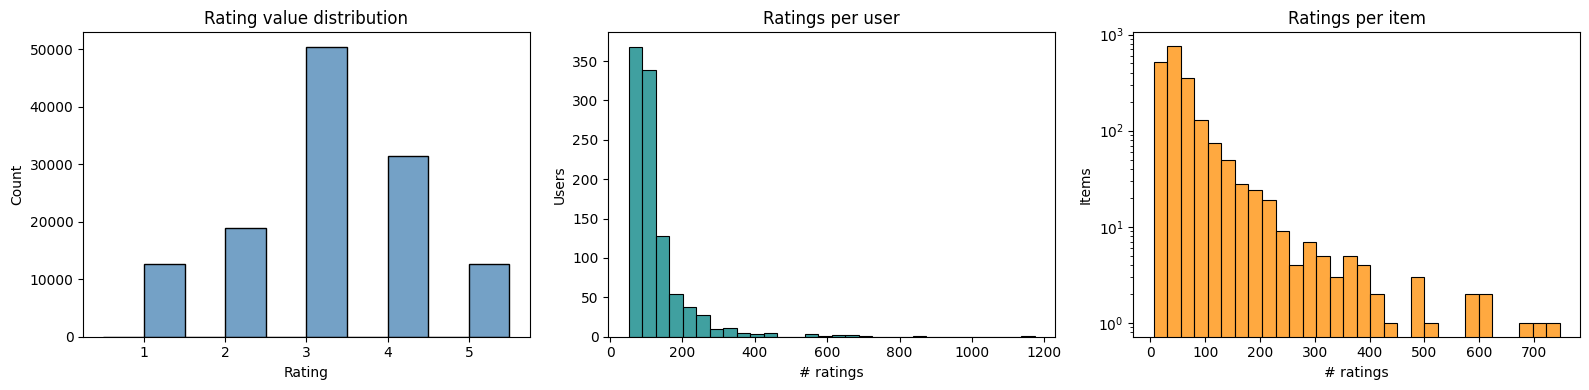

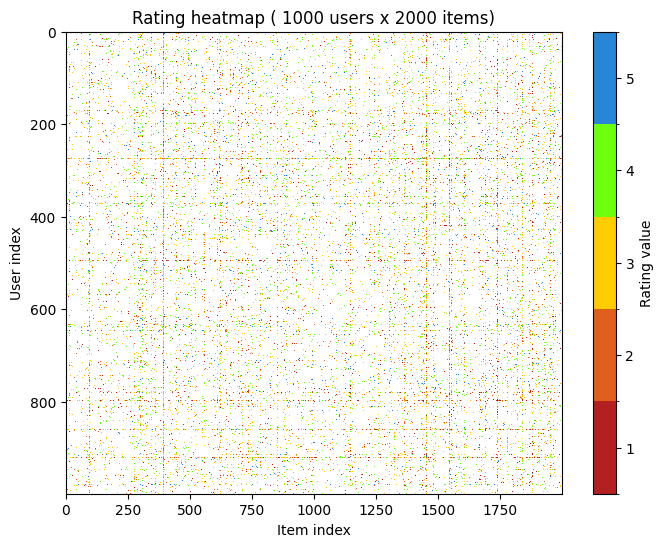

In [32]:
ratings_df = pd.DataFrame(R_syn)

vals = ratings_df.values
mask = ~np.isnan(vals)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(ratings_df.stack(), bins=np.arange(0.5, 5.6, 0.5), ax=axes[0], color="steelblue")
axes[0].set_title("Rating value distribution")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")


user_counts = mask.sum(axis=1)
sns.histplot(user_counts, bins=30, ax=axes[1], color="teal")
axes[1].set_title("Ratings per user")
axes[1].set_xlabel("# ratings")
axes[1].set_ylabel("Users")
# axes[1].set_yscale("log")


item_counts = mask.sum(axis=0)
sns.histplot(item_counts, bins=30, ax=axes[2], color="darkorange")
axes[2].set_title("Ratings per item")
axes[2].set_xlabel("# ratings")
axes[2].set_ylabel("Items")
axes[2].set_yscale("log")


plt.tight_layout()
plt.show()

# Heatmap with exactly 5 colors (one per rating), NaNs in light gray
plt.figure(figsize=(8, 6))
subset = ratings_df.iloc[:1000, :2000]
subset_vals = subset.to_numpy()
subset_masked = np.ma.masked_invalid(subset_vals)

colors = ["#b41f1f", "#e15f1d", "#ffcc00", "#6eff0e", "#2787d6"]  # 5 distinct colors
cmap = ListedColormap(colors).with_extremes(bad="white")
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = BoundaryNorm(bounds, cmap.N)

im = plt.imshow(
    subset_masked,
    aspect="auto",
    cmap=cmap,
    norm=norm,
    interpolation="nearest",
)
plt.title("Rating heatmap ( 1000 users x 2000 items)")
plt.xlabel("Item index")
plt.ylabel("User index")
plt.colorbar(im, label="Rating value", ticks=[1, 2, 3, 4, 5])
plt.show()
